# Continuous Control

---

This notebook trains the ML-Agents environment [Reacher](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#reacher) environment using  Deep Deterministic Policy Gradient.

### 1. Start the Environment

First import the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [13]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
import numpy as np
import time
from itertools import count

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [1]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='./Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examining the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 4. Training the agent using DDPG

DDPG adapts the ideas of Deep Q-Learning to the continuous action domain.
The actor network approximates the optimal policy deterministically (best believed action). 
The critic evaluates the optimal action value function using the best believed action given by the actor network.
DDPG also uses a repĺay buffer where experience tuples are stored.

From [Continuous control with deep reinforcement learning](https://arxiv.org/abs/1509.02971v5) we can find a description of the algorithm.

>Initialize critic network $Q(s,a|\theta^{Q})$ and actor $\mu(s|\theta^{\mu})$ with weights $\theta^Q$ and $\theta^{\mu}$ 
<br>
>Initialize target network $Q'$ and $\mu'$ with weigths $\theta^{Q'} \leftarrow \theta^Q $ and $\theta^{\mu'} \leftarrow \theta^{\mu}$
<br>
>Initialize replay buffer R
<br>
> for episode = 1, M do
>> Initialize a random process $\mathrm{N}$ for action exploration  
>> Receive initial observation state $s_1$
<br>
>> for t = 1, T do
>>>Select action $a_t = µ(s^t|\theta^µ) + N_t$ according to the current policy and exploration noise <br>
>>>Execute action at and observe reward rt and observe new state $s_{t+1}$ <br>
>>>Store transition (st, at, rt, st+1) in R <br>
>>>Sample a random minibatch of N transitions (si, ai, ri, si+1) from R  <br>
>>>Set $y_i = r_i + \gamma Q'(s_{i+1}, \mu'(s_{i+1}|\theta^{µ'})|\theta^{Q'})$ <br>
>>>Update critic by minimizing the loss: $L = \frac{1}{N} \Sigma_i (y_i − Q(s_i , a_i |\theta^Q))^2$ <br>
>>>Update the actor policy using the sampled policy gradient:<br>
>>>$$\nabla_{\theta^{\mu}}J \approx {1}/{N} \Sigma_i \nabla_a Q(s,a| \theta^Q)|_{s=s_i, a = \mu(s_i)}  \nabla_{\theta^{\mu}} \mu (s|\theta^\mu)|_{s_i}$$
>>> Update the target networks:
>>> $$ \theta^{Q'} \leftarrow \tau \theta^Q + (1-\tau) \theta^{Q'}$$
>>> $$ \theta^{\mu'} \leftarrow \tau \mu^Q + (1-\tau) \theta^{\mu'}$$

Here both the critic newtork and the actor network have 2 hidden layers with 128 nodes each.
The parameters used were:

| Parameter Description|  Variable  | Value |
|-----------|------------|------|
|Size of the replay buffer D|BUFFER_SIZE|1e6|
|Mini-batch size|BATCH_SIZE|256|
|Discount factor|GAMMA|0.99|
|$\tau$ for soft update of target parameters|TAU|1e-3|
|Actor learning rate|LR|1e-3|
|Actor learning rate|LR|1e-3|
|L2 weight decay|WEIGHT_DECAY|0|

In [15]:
from ddpg_agent import Agent
agent = Agent(state_size=state_size, action_size=action_size, random_seed=2)

Episode 10, Average Score: 0.35, Max: 1.94, Min: 0.11, Time: 7.14
Episode 20, Average Score: 0.78, Max: 3.43, Min: 0.13, Time: 8.17
Episode 30, Average Score: 1.17, Max: 5.73, Min: 0.35, Time: 9.62
Episode 40, Average Score: 2.13, Max: 10.74, Min: 2.18, Time: 10.32
Episode 50, Average Score: 3.23, Max: 13.49, Min: 3.92, Time: 11.20
Episode 60, Average Score: 4.68, Max: 30.33, Min: 6.82, Time: 12.05
Episode 70, Average Score: 6.16, Max: 24.18, Min: 11.69, Time: 10.59
Episode 80, Average Score: 7.98, Max: 30.59, Min: 15.82, Time: 10.52
Episode 90, Average Score: 10.12, Max: 36.26, Min: 27.07, Time: 10.64
Episode 100, Average Score: 12.57, Max: 39.19, Min: 29.96, Time: 10.54
Episode 110, Average Score: 16.20, Max: 38.76, Min: 32.84, Time: 10.48
Episode 120, Average Score: 19.82, Max: 38.75, Min: 33.75, Time: 10.53
Episode 130, Average Score: 23.39, Max: 38.66, Min: 33.96, Time: 10.61
Episode 140, Average Score: 26.56, Max: 39.35, Min: 30.63, Time: 10.57
Episode 150, Average Score: 29.46, 

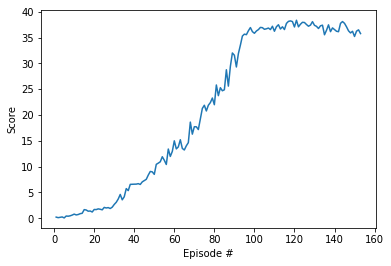

In [16]:
def ddpg(n_episodes=2000, max_t=2000):
    scores_deque = deque(maxlen=100)
    average_scores = []                                        # average of the score of the 20 agents for each episode
        
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.reset()
        
        timestep = time.time()
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            agent.step(states, actions, rewards, next_states, dones, t)
            states = next_states                               # roll over states to next time step
            scores += rewards                                  # update the score (for each agent)            
            if np.any(dones):                                  # exit loop if episode finished
                break
        
        score = np.mean(scores)
        scores_deque.append(score)
        average_scores.append(score)      
        
        if i_episode % 10 == 0:
            print('\rEpisode {}, Average Score: {:.2f}, Max: {:.2f}, Min: {:.2f}, Time: {:.2f}'\
                .format(i_episode, np.mean(scores_deque), np.max(scores), np.min(scores), time.time() - timestep), end="\n")  
            
        if np.mean(scores_deque) >= 30.0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))            
            break            
            
    return average_scores


scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Training the agent using Proximal Policy Optimization

#### 5.1 Learning Algorithm
Proximal Policy Optimization is a policy gradient algorithm that solves some issues with the REINFORCE algorithm. REINFORCE has three main problems:
- The gradient estimate is noisy: trajectories may not be representative.
- No clear credit assignment: trajectories may have good and bad actions but they are reinforced depending only on the final total output.
- Inefficient update process: trajectories are not reused.

To solve these problems the folowing changes are made:
- Noise Reduction: 
    - Multiple trajectories are sampled and the gradient is estimated using the average.
    -  Reward Normalization
$$R_i \leftarrow
\frac{R_i -\mu}{\sigma}
\qquad
\mu = \frac{1}{N}\sum_i^N R_i
\qquad
\sigma = \sqrt{\frac{1}{N}\sum_i (R_i - \mu)^2}$$

- Credit assignment: 

    To properly assign credit to the an action at timestep we should ignore the past reward. So a better policy gradient would simply have the future reward as the coefficient: 
    
    $$g=\sum_t R_t^{\rm future}\nabla_{\theta}\log \pi_\theta(a_t|s_t)$$
    
- Importance Sampling. With this technique we can reuse old tragectories to compute averages for the new policy, by adding the re-weighting factor:

$$
\frac{P(\tau;\theta')}{P(\tau;\theta)}
=\frac
{\pi_{\theta'}(a_1|s_1)\, \pi_{\theta'}(a_2|s_2)\, \pi_{\theta'}(a_3|s_3)\,...}
{\pi_\theta(a_1|s_1) \, \pi_\theta(a_2|s_2)\, \pi_\theta(a_2|s_2)\, ...}
$$



The PPO algorithm can be sumarized as folows:
##### 1. Collect multiple trajectories based on $\pi_{\theta}$ and initialize $\theta^{'} = \theta$.
    
##### 2. Compute the gradient of the clipped surrogate function using the trajectories. 
The surrogate function is given by: 
        
$$ g=\nabla_{\theta'} L_{\rm sur}(\theta', \theta)$$
$$
            L_{\rm sur}(\theta', \theta)=
            \sum_t
            \frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}R_t^{\rm future}
        $$ 
    The clipped version is given by: 
$$L^{\rm clip}_{\rm sur}
(\theta',\theta)=
\sum_t \min\left\{
\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}R_t^{\rm future}
, 
{\rm clip}_\epsilon\!\!
\left(
\frac{\pi_{\theta'}(a_t|s_t)}
{\pi_{\theta}(a_t|s_t)}
\right)
R_t^{\rm future}
\right\}$$ Wich just clips the function in the interval $[1-\epsilon, 1 + \epsilon]$
        
##### 3. Update $\theta^{'}$ using: 
$$\theta^{'} \leftarrow \theta^{'} + \alpha \nabla_{\theta^{'}} L^{clip}_{sur}(\theta^{'}, \theta)$$

##### 4. Repeat steps 2-3 without generating new trajectories.
##### 5. Set ${\theta} = \theta^{'}$ and loop to step 1.

#### 5.2 Implementation
The implementation of Proximal Policy Optimization agent used here is found at https://github.com/ShangtongZhang/DeepRL. A custom run_steps function is defined to store the last 100 scores and print its mean. ReacherTask class interfaces the UnityAgents environment with DeepRL library.

In [7]:
from deep_rl import *

def run_steps_custom(agent, target_score):
    random_seed()
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    rewards_deque = deque(maxlen=100) # deque to store the mean score of the 20 agents for the last 100 episodes
    rewards_all   = []                # deque to store all scores
    while True:
        rewards = agent.episode_rewards
        if len(rewards):
            rewards_deque.append(np.mean(rewards))
            rewards_all.append(np.mean(rewards))
        if config.log_interval and not agent.total_steps % config.log_interval and len(agent.episode_rewards):
            config.logger.info('Episode %d: %.2f/%.2f/%.2f/%.2f (mean/median/min/max). Mean score %.2f last %d episodes' % (
                len(rewards_all), np.mean(rewards), np.median(rewards), np.min(rewards), np.max(rewards),  np.mean(rewards_deque), len(rewards_deque)))
            agent.episode_rewards = []
            t0 = time.time()
        if len(rewards) and (np.mean(rewards_deque) >= target_score):
            agent.save('./data/model-%s-%s-%s.bin' % (agent_name, config.task_name, config.tag))
            res = True, rewards_deque, rewards_all
            agent.close()
            return res
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            agent.close()
            return False, None, None
            break
        agent.step()
        
        
class ReacherTask(BaseTask):
    def __init__(self):
        BaseTask.__init__(self)
        self.name = 'Reacher'
        self.env = env
        self.action_dim = brain.vector_action_space_size
        self.state_dim = brain.vector_observation_space_size
        
    def reset(self):
        env_info = self.env.reset(train_mode=True)[brain_name]
        return np.array(env_info.vector_observations)

    def step(self, action):
        action = np.clip(action, -1, 1)
        env_info = self.env.step(action)[brain_name]
        next_state = env_info.vector_observations   # next state
        reward = env_info.rewards                   # reward
        done = env_info.local_done
        if np.any(done):
            next_state = self.reset()
        return np.array(next_state), np.array(reward), np.array(done), None
    
    def seed(self, random_seed):
        pass
    
def ppo_continuous():
    config = Config()
    config.num_workers = num_agents
    task_fn = lambda : ReacherTask()
    config.task_fn = task_fn
    config.eval_env = task_fn()

    config.network_fn = lambda: GaussianActorCriticNet(
        config.state_dim, config.action_dim, actor_body=FCBody(config.state_dim),
        critic_body=FCBody(config.state_dim))
    config.optimizer_fn = lambda params: torch.optim.Adam(params, 3e-4, eps=1e-5)
    config.discount = 0.99
    config.use_gae = True
    config.gae_tau = 0.95
    config.gradient_clip = 5
    config.rollout_length = 2048
    config.optimization_epochs = 10
    config.num_mini_batches = 32
    config.ppo_ratio_clip = 0.2
    config.log_interval = 2048
    config.max_steps = 2e7
    config.logger = get_logger()
    return run_steps_custom(PPOAgent(config), 30.0)
    
success, rewards_deque, rewards_all = ppo_continuous()

INFO:MAIN:Episode 1: 0.12/0.00/0.00/1.15 (mean/median/min/max). Mean score 0.12 last 1 episodes
INFO:MAIN:Episode 2: 0.19/0.00/0.00/0.97 (mean/median/min/max). Mean score 0.15 last 2 episodes
INFO:MAIN:Episode 3: 0.19/0.07/0.00/0.94 (mean/median/min/max). Mean score 0.17 last 3 episodes
INFO:MAIN:Episode 4: 0.27/0.20/0.00/0.98 (mean/median/min/max). Mean score 0.19 last 4 episodes
INFO:MAIN:Episode 5: 0.41/0.36/0.00/1.88 (mean/median/min/max). Mean score 0.24 last 5 episodes
INFO:MAIN:Episode 6: 0.80/0.63/0.00/2.40 (mean/median/min/max). Mean score 0.33 last 6 episodes
INFO:MAIN:Episode 7: 0.89/0.81/0.00/2.13 (mean/median/min/max). Mean score 0.41 last 7 episodes
INFO:MAIN:Episode 8: 1.25/1.21/0.34/3.06 (mean/median/min/max). Mean score 0.51 last 8 episodes
INFO:MAIN:Episode 9: 1.35/1.27/0.22/2.74 (mean/median/min/max). Mean score 0.61 last 9 episodes
INFO:MAIN:Episode 10: 1.80/1.67/0.25/3.49 (mean/median/min/max). Mean score 0.73 last 10 episodes
INFO:MAIN:Episode 11: 1.65/1.68/0.36/3

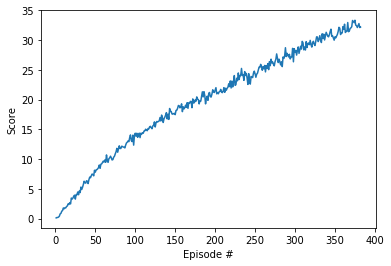

In [10]:
if success:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(rewards_all)+1), rewards_all)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

In [ ]:
env.close()

### 6. Ideas for Future Work
Results could be improved tunning hyperparameters for both the methods used. 

In the case of DDPG, we could vary the size of mini-batch, learning rates and $\tau$ as well as change the actor and critic network, increasing the number of layers as well the number of nodes.

Algorithms such as A3C/A2C and D4PG could be tested for this problem.